### MODEL DEFINITION 
Run this cell before all others.

MAKE sure you have uploaded dataset.py and backbone.py
## 

In [1]:
#####################SOLO HEAD#####################

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy import ndimage
from dataset import *
from functools import partial
import copy
import matplotlib.pyplot as plt
from backbone import *

class SOLOHead(nn.Module):
    def __init__(self,
                 num_classes,
                 in_channels=256,
                 seg_feat_channels=256,
                 stacked_convs=7,
                 strides=[8, 8, 16, 32, 32],
                 scale_ranges=((1, 96), (48, 192), (96, 384), (192, 768), (384, 2048)),
                 epsilon=0.2,
                 num_grids=[40, 36, 24, 16, 12],
                 cate_down_pos=0,
                 with_deform=False,
                 mask_loss_cfg=dict(weight=3),
                 cate_loss_cfg=dict(gamma=2,
                                alpha=0.25,
                                weight=1),
                 postprocess_cfg=dict(cate_thresh=0.2,
                                      ins_thresh=0.5,
                                      pre_NMS_num=50,
                                      keep_instance=5,
                                      IoU_thresh=0.5)):
        super(SOLOHead, self).__init__()
        self.num_classes = num_classes
        self.seg_num_grids = num_grids
        self.cate_out_channels = self.num_classes - 1
        self.in_channels = in_channels
        self.seg_feat_channels = seg_feat_channels
        self.stacked_convs = stacked_convs
        self.strides = strides
        self.epsilon = epsilon
        self.cate_down_pos = cate_down_pos
        self.scale_ranges = scale_ranges
        self.with_deform = with_deform

        self.mask_loss_cfg = mask_loss_cfg
        self.cate_loss_cfg = cate_loss_cfg
        self.postprocess_cfg = postprocess_cfg
        # initialize the layers for cate and mask branch, and initialize the weights
        self._init_layers()
        self._init_weights()

        # check flag
        assert len(self.ins_head) == self.stacked_convs
        assert len(self.cate_head) == self.stacked_convs
        assert len(self.ins_out_list) == len(self.strides)
        pass

    # This function build network layer for cate and ins branch
    # it builds 4 self.var
        # self.cate_head is nn.ModuleList 7 inter-layers of conv2d
        # self.ins_head is nn.ModuleList 7 inter-layers of conv2d
        # self.cate_out is 1 out-layer of conv2d
        # self.ins_out_list is nn.ModuleList len(self.seg_num_grids) out-layers of conv2d, one for each fpn_feat
    def _init_layers(self):
        ## TODO initialize layers: stack intermediate layer and output layer
        # define groupnorm
        num_groups = 32
        # initial the two branch head modulelist
        
        self.cate_head = nn.ModuleList([nn.Sequential(torch.nn.Conv2d(256,256,kernel_size=3,padding=1, stride=1, bias=False), torch.nn.GroupNorm(num_groups, 256), torch.nn.ReLU(inplace = False)) for i in range(7)])
        self.ins_head  = nn.ModuleList()
        self.ins_head.append(nn.Sequential(torch.nn.Conv2d(256+2,256,kernel_size=3,padding=1, stride=1, bias=False), torch.nn.GroupNorm(num_groups, 256), torch.nn.ReLU(inplace = False)))
        self.ins_head.extend([nn.Sequential(torch.nn.Conv2d(256,256,kernel_size=3,padding=1, stride=1, bias=False), torch.nn.GroupNorm(num_groups, 256), torch.nn.ReLU(inplace = False)) for i in range(6)])
        self.cate_out = nn.Sequential(torch.nn.Conv2d(256, 3,kernel_size=3,padding=1, bias=True), torch.nn.Sigmoid())
        self.ins_out_list = nn.ModuleList()
        for g in self.seg_num_grids:
            self.ins_out_list.append(nn.Sequential(torch.nn.Conv2d(256, g**2, kernel_size=1, bias=True),torch.nn.Sigmoid()))
        
    # This function initialize weights for head network
    def init_weights(self, l):
        if type(l) == nn.Conv2d:
          nn.init.xavier_uniform_(l.weight)
          if l.bias != None:
            l.bias.data.fill_(0)

           
    def _init_weights(self):
        ## TODO: initialize the weights
        self.cate_head.apply(self.init_weights)
        self.ins_head.apply(self.init_weights)
        self.cate_out.apply(self.init_weights)        
        for i in self.ins_out_list:
          i.apply(self.init_weights)

    # Forward function should forward every levels in the FPN.
    # this is done by map function or for loop
    # Input:
        # fpn_feat_list: backout_list of resnet50-fpn
    # Output:
        # if eval = False
            # cate_pred_list: list, len(fpn_level), each (bz,C-1,S,S)
            # ins_pred_list: list, len(fpn_level), each (bz, S^2, 2H_feat, 2W_feat)
        # if eval==True
            # cate_pred_list: list, len(fpn_level), each (bz,S,S,C-1) / after point_NMS
            # ins_pred_list: list, len(fpn_level), each (bz, S^2, Ori_H, Ori_W) / after upsampling
    def forward(self,
                fpn_feat_list,
                eval=False):
        new_fpn_list = self.NewFPN(fpn_feat_list)  # stride[8,8,16,32,32]
        assert new_fpn_list[0].shape[1:] == (256,100,136)
        quart_shape = [new_fpn_list[0].shape[-2]*2, new_fpn_list[0].shape[-1]*2]  # stride: 4
        # TODO: use MultiApply to compute cate_pred_list, ins_pred_list. Parallel w.r.t. feature level.
        
        ###MODIFICATIONS####
        #self.forward_single_level(fpn_feat_list[0],0)
 
        cate_pred_list, ins_pred_list = self.MultiApply(self.forward_single_level, new_fpn_list,
                                                        list(range(len(new_fpn_list))), eval=eval, upsample_shape=quart_shape)
        
        ####################
        
        assert len(new_fpn_list) == len(self.seg_num_grids)

        # assert cate_pred_list[1].shape[1] == self.cate_out_channels
        assert ins_pred_list[1].shape[1] == self.seg_num_grids[1]**2
        assert cate_pred_list[1].shape[2] == self.seg_num_grids[1]
        
        #del fpn_feat_list
        return cate_pred_list, ins_pred_list

    # This function upsample/downsample the fpn level for the network
    # In paper author change the original fpn level resolution
    # Input:
        # fpn_feat_list, list, len(FPN), stride[4,8,16,32,64]
    # Output:
    # new_fpn_list, list, len(FPN), stride[8,8,16,32,32]
    def NewFPN(self, fpn_feat_list):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        new_fpn_list = []
        new_fpn_list.append(torch.nn.functional.interpolate(fpn_feat_list[0], size=(fpn_feat_list[1].shape[2], fpn_feat_list[1].shape[3]), mode='bilinear'))                        
        new_fpn_list.append(fpn_feat_list[1])
        new_fpn_list.append(fpn_feat_list[2])
        new_fpn_list.append(fpn_feat_list[3])
        new_fpn_list.append(torch.nn.functional.interpolate(fpn_feat_list[4], size=(fpn_feat_list[3].shape[2], fpn_feat_list[3].shape[3]), mode='bilinear'))
        
        for i in range(len(new_fpn_list)):
                new_fpn_list[i] = new_fpn_list[i].to(device) 
        
        #del fpn_feat_list
        return new_fpn_list
        
    # This function forward a single level of fpn_featmap through the network
    # Input:
        # fpn_feat: (bz, fpn_channels(256), H_feat, W_feat)
        # idx: indicate the fpn level idx, num_grids idx, the ins_out_layer idx
    # Output:
        # if eval==False
            # cate_pred: (bz,C-1,S,S)
            # ins_pred: (bz, S^2, 2H_feat, 2W_feat)
        # if eval==True
            # cate_pred: (bz,S,S,C-1) / after point_NMS
            # ins_pred: (bz, S^2, Ori_H/4, Ori_W/4) / after upsampling
    def forward_single_level(self, fpn_feat, idx, eval=False, upsample_shape=None):
        # upsample_shape is used in eval mode
        ## TODO: finish forward function for single level in FPN.
        ## Notice, we distinguish the training and inference.
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        cate_pred = fpn_feat
        ins_pred  = torch.zeros((fpn_feat.shape[0], fpn_feat.shape[1]+2, fpn_feat.shape[2], fpn_feat.shape[3])).to(device) 
        ins_pred[:,:fpn_feat.shape[1],:,:] = fpn_feat
        #ins_pred = fpn_feat
        num_grid = self.seg_num_grids[idx]  # current level grid
        #ins_pred = torch.zeros((fpn_feat.shape[0], fpn_feat.shape[1]+2, fpn_feat.shape[2], fpn_feat.shape[3]))
        ####MY CODE#####
        cate_pred = torch.nn.functional.interpolate(cate_pred, (num_grid, num_grid))
        for i, l in enumerate(self.cate_head):
            cate_pred = l(cate_pred) 
        
        cate_pred = self.cate_out(cate_pred)
        #print("num grid:", num_grid)
        #print("FPN shape", fpn_feat.shape)
        #print("Category Prediciton", cate_pred.shape)
        yy,xx = torch.meshgrid([torch.linspace(0.0, 1.0, fpn_feat.shape[2]), torch.linspace(0.0, 1.0, fpn_feat.shape[3])])
        #print("xx:", xx)
        #print("yy:", yy)
        #print(xx.shape)
        #print(yy.shape)
        #print(fpn_feat.shape)
        ins_pred[:,fpn_feat.shape[1],:,:]   = xx
        ins_pred[:,fpn_feat.shape[1]+1,:,:] = yy 
        
        #print(fpn_feat.shape)
        #print(xx.shape)
        #print(yy.shape)
        #print("PRE Ins Pred:", ins_pred.shape)
        #SET ALL LAYERS IN EVAL MODE
        for i, l in enumerate(self.ins_head):
            ins_pred = l(ins_pred)

        ins_pred = torch.nn.functional.interpolate(ins_pred, (fpn_feat.shape[2]*2, fpn_feat.shape[3]*2), 
                                                   mode='bilinear', align_corners=True) #Align Corner?        
        ins_pred = self.ins_out_list[idx](ins_pred)

        #print("INS Predictions", ins_pred.shape)
        ################
        # in inference time, upsample the pred to (ori image size/4)
        
        if eval == True:
            ## TODO resize ins_pred 
            ins_pred = torch.nn.functional.interpolate(ins_pred, upsample_shape)
            cate_pred = self.points_nms(cate_pred).permute(0,2,3,1)

        # check flag
        if eval == False:
            assert cate_pred.shape[1:] == (3, num_grid, num_grid)
            assert ins_pred.shape[1:] == (num_grid**2, fpn_feat.shape[2]*2, fpn_feat.shape[3]*2)
        else:
            pass
        
        return cate_pred, ins_pred

    # Credit to SOLO Author's code
    # This function do a NMS on the heat map(cate_pred), grid-level
    # Input:
        # heat: (bz,C-1, S, S)
    # Output:
        # (bz,C-1, S, S)
    def points_nms(self, heat, kernel=2):
        # kernel must be 2
        hmax = nn.functional.max_pool2d(
            heat, (kernel, kernel), stride=1, padding=1)
        keep = (hmax[:, :, :-1, :-1] == heat).float()
        return heat * keep

    # This function compute loss for a batch of images
    # input:
        # cate_pred_list: list, len(fpn_level), each (bz,C-1,S,S)
        # ins_pred_list: list, len(fpn_level), each (bz, S^2, 2H_feat, 2W_feat)
        # ins_gts_list: list, len(bz), list, len(fpn), (S^2, 2H_f, 2W_f)
        # ins_ind_gts_list: list, len(bz), list, len(fpn), (S^2,)
        # cate_gts_list: list, len(bz), list, len(fpn), (S, S), {1,2,3}
    # output:
        # cate_loss, mask_loss, total_loss
    def loss(self,
             cate_pred_list,
             ins_pred_list,
             ins_gts_list,
             ins_ind_gts_list,
             cate_gts_list):
        ## TODO: compute loss, vecterize this part will help a lot. To avoid potential ill-conditioning, if necessary, add a very small number to denominator for focalloss and diceloss computation.
        ## uniform the expression for ins_gts & ins_preds 
        # ins_gts: list, len(fpn), (active_across_batch, 2H_feat, 2W_feat) 
        # ins_preds: list, len(fpn), (active_across_batch, 2H_feat, 2W_feat)
        
        #Check this
        ins_gts = [torch.cat([ins_labels_level_img[ins_ind_labels_level_img, ...]
                               for ins_labels_level_img, ins_ind_labels_level_img in zip(ins_labels_level, ins_ind_labels_level)], 0)
                   for ins_labels_level, ins_ind_labels_level in zip(zip(*ins_gts_list), zip(*ins_ind_gts_list))]
        
        ins_preds = [torch.cat([ins_preds_level_img[ins_ind_labels_level_img, ...] 
                                for ins_preds_level_img, ins_ind_labels_level_img in zip(ins_preds_level, ins_ind_labels_level)], 0) 
                     for ins_preds_level, ins_ind_labels_level in zip(ins_pred_list, zip(*ins_ind_gts_list))]
                      
        cate_gts = [torch.cat([cate_gts_level_img.flatten() for cate_gts_level_img in cate_gts_level]) # cate_gts_level_im
                    for cate_gts_level in zip(*cate_gts_list)]
                     
        cate_gts = torch.cat(cate_gts)
        cate_preds = [cate_pred_level.permute(0,2,3,1).reshape(-1, self.cate_out_channels) for cate_pred_level in cate_pred_list]
        cate_preds = torch.cat(cate_preds, 0)

        fl = self.FocalLoss(cate_preds, cate_gts)
        dl = self.DiceLoss(ins_preds, ins_gts)

        return fl, self.mask_loss_cfg['weight'] * dl

    # This function compute the DiceLoss
    # Input:
        # mask_pred: (2H_feat, 2W_feat)
        # mask_gt: (2H_feat, 2W_feat)
    # Output: dice_loss, scalar
    def DiceLoss(self, mask_pred, mask_gt):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        dice_loss = torch.tensor(0, dtype=torch.float32).to(device)
        active_cells = 0
        eps = 0.0001
        for i in range(len(mask_pred)):
          active_cells += mask_pred[i].shape[0]
          for m in range(mask_pred[i].shape[0]):
              m_pred = mask_pred[i][m].to(device)
              m_gt   = mask_gt[i][m].to(device)
              dl = (2*torch.sum(m_pred * m_gt))/(torch.sum(torch.pow(m_pred,2)) + torch.sum(torch.pow(m_gt,2)))# + eps) 
              dice_loss += (1.0-dl)

        if active_cells == 0:
          print('active cells = 0')
          for i in range(len(mask_pred)):
            print('Gt shape = ', mask_gt[i].shape)
          return dice_loss
        return dice_loss/active_cells

    # This function compute the cate loss
    # Input:
        # cate_preds: (num_entry, C-1)
        # cate_gts: (num_entry,)
    # Output: focal_loss, scalar
    def FocalLoss(self, cate_preds, cate_gts):
        ## TODO: compute focalloss
 
        eps = 0.0000001
        cate_gts = cate_gts.type(torch.LongTensor)
        one_hot  = torch.nn.functional.one_hot(cate_gts, num_classes=4)
        cate_gts_unflattened = one_hot[:,1:]
        #print("cate_gts_unflattened", cate_gts_unflattened.shape)
        #print("one hot", one_hot.shape)
        pt = torch.flatten(cate_preds) 
        #print(pt)
        cate_gts_flattened   = torch.flatten(cate_gts_unflattened)

        #print("cate_gts", cate_gts.shape)
        #print("pt", pt.shape)

        factor = 0.25
        gamma = 2

        a = torch.ones(cate_gts_flattened.shape,device=device) * factor

        idx = cate_gts_flattened<1
        a[idx]  = 1 - a[idx] 
        pt[idx] = 1 - pt[idx]

        fl = (torch.sum(-a*(torch.pow((1-pt),gamma))*torch.log(pt+eps)) + eps)/(cate_gts.shape[0]*3)
        
        return fl
      
    def MultiApply(self, func, *args, **kwargs):
        pfunc = partial(func, **kwargs) if kwargs else func
        map_results = map(pfunc, *args)

        return tuple(map(list, zip(*map_results)))

    # This function build the ground truth tensor for each batch in the training
    # Input:
        # ins_pred_list: list, len(fpn_level), each (bz, S^2, 2H_feat, 2W_feat)
        # / ins_pred_list is only used to record feature map
        # bbox_list: list, len(batch_size), each (n_object, 4) (x1y1x2y2 system)
        # label_list: list, len(batch_size), each (n_object, )
        # mask_list: list, len(batch_size), each (n_object, 800, 1088)
    # Output:
        # ins_gts_list: list, len(bz), list, len(fpn), (S^2, 2H_f, 2W_f)
        # ins_ind_gts_list: list, len(bz), list, len(fpn), (S^2,)
        # cate_gts_list: list, len(bz), list, len(fpn), (S, S), {1,2,3}
    def target(self,
               ins_pred_list,
               bbox_list,
               label_list,
               mask_list):
        # TODO: use MultiApply to compute ins_gts_list, ins_ind_gts_list, cate_gts_list. Parallel w.r.t. img mini-batch
        # remember, you want to construct target of the same resolution as prediction output in training
        featmap_sizes = []
        for i,pred in enumerate(ins_pred_list):
          featmap_sizes.append([ins_pred_list[i].shape[2], ins_pred_list[i].shape[3]] )
        
        featmap_sizes = [featmap_sizes for i in range(len(mask_list))]

        # self.target_single_img(bbox_list[0], label_list[0], mask_list[0], featmap_sizes)
        
        ins_gts_list, ins_ind_gts_list, cate_gts_list = self.MultiApply(self.target_single_img, 
                                                                              bbox_list,
                                                                              label_list, 
                                                                              mask_list, 
                                                                              featmap_sizes)
        # check flag
        assert ins_gts_list[0][1].shape == (self.seg_num_grids[1]**2, 200, 272)
        assert ins_ind_gts_list[0][1].shape == (self.seg_num_grids[1]**2,)
        assert cate_gts_list[0][1].shape == (self.seg_num_grids[1], self.seg_num_grids[1])
        '''
        del featmap_sizes
        del ins_pred_list
        del bbox_list
        del label_list
        del mask_list
        '''
        return ins_gts_list, ins_ind_gts_list, cate_gts_list
    # -----------------------------------
    ## process single image in one batch
    # -----------------------------------
    # input:
        # gt_bboxes_raw: n_obj, 4 (x1y1x2y2 system)
        # gt_labels_raw: n_obj,
        # gt_masks_raw: n_obj, H_ori, W_ori
        # featmap_sizes: list of shapes of featmap
    # output:
        # ins_label_list: list, len: len(FPN), (S^2, 2H_feat, 2W_feat)
        # cate_label_list: list, len: len(FPN), (S, S)
        # ins_ind_label_list: list, len: len(FPN), (S^2, )
    def target_single_img(self,
                          gt_bboxes_raw,
                          gt_labels_raw,
                          gt_masks_raw,
                          featmap_sizes=None):
        ## TODO: finish single image target build
        # compute the area of every object in this single image
        h, w = gt_masks_raw.shape[2], gt_masks_raw.shape[3]
        # Area normalized by height and width of image
        area   = torch.sqrt((gt_bboxes_raw[:,2] - gt_bboxes_raw[:,0]) * (gt_bboxes_raw[:,3] - gt_bboxes_raw[:,1]))
        region = torch.zeros((gt_masks_raw.shape[0],4))

        for i in range(gt_masks_raw.shape[0]):
            centre_of_mass = ndimage.measurements.center_of_mass(gt_masks_raw[i,0,:,:].numpy()) 
            # region[i, 0] = centre_of_mass[0]
            # region[i, 1] = centre_of_mass[1]
            region[i, 0] = centre_of_mass[1]
            region[i, 1] = centre_of_mass[0]

        region[:,2] = (gt_bboxes_raw[:,2] - gt_bboxes_raw[:,0]) *0.2/w          #Width 
        region[:,3] = (gt_bboxes_raw[:,3] - gt_bboxes_raw[:,1]) *0.2/h          #Height
        
        #Rescaling Centers
        region[:,0] = region[:,0]/w 
        region[:,1] = region[:,1]/h
        
        # initial the output list, each entry for one featmap
        ins_label_list = []
        ins_ind_label_list = []
        cate_label_list = []
        # no_of_zeros = 0 
        for i, size in enumerate(featmap_sizes):
            if (i==0):
                idx = area<96
            elif i==1:
                idx = torch.logical_and(area<192,area>48)
            elif i==2: 
                idx = torch.logical_and(area<384,area>96)
            elif i==3: 
                idx = torch.logical_and(area<768,area>192)
            elif i==4: 
                idx = area>=384
            
            if torch.sum(idx) == 0:
                cat_label = torch.zeros((self.seg_num_grids[i],self.seg_num_grids[i]))
                ins_label = torch.zeros((self.seg_num_grids[i]**2, size[0], size[1]))
                ins_index_label = torch.zeros(self.seg_num_grids[i]**2, dtype=torch.bool)

                cate_label_list.append(cat_label)
                ins_label_list.append(ins_label)
                ins_ind_label_list.append(ins_index_label)
                # no_of_zeros += 1
                continue
            
            region_idx = region[idx,:]
            left_ind   = ((region_idx[:,0] - region_idx[:,2]/2)*self.seg_num_grids[i]).int()
            right_ind  = ((region_idx[:,0] + region_idx[:,2]/2)*self.seg_num_grids[i]).int()
            top_ind    = ((region_idx[:,1] - region_idx[:,3]/2)*self.seg_num_grids[i]).int()
            bottom_ind = ((region_idx[:,1] + region_idx[:,3]/2)*self.seg_num_grids[i]).int()

            left   = torch.max(torch.zeros_like(left_ind)                              , left_ind  )
            right  = torch.min(torch.ones_like(right_ind)*(self.seg_num_grids[i] - 1)  , right_ind )
            top    = torch.max(torch.zeros_like(top_ind)                               , top_ind   )
            bottom = torch.min(torch.ones_like(bottom_ind)*(self.seg_num_grids[i] - 1) , bottom_ind)

            xA = torch.max(left    , (region_idx[:,0]*self.seg_num_grids[i]).int() - 1)
            xB = torch.min(right   , (region_idx[:,0]*self.seg_num_grids[i]).int() + 1)
            yA = torch.max(top     , (region_idx[:,1]*self.seg_num_grids[i]).int() - 1)
            yB = torch.min(bottom  , (region_idx[:,1]*self.seg_num_grids[i]).int() + 1)

            #Size of ins_label = S^2 x 2H_feat x 2W_feat
            cat_label = torch.zeros((self.seg_num_grids[i],self.seg_num_grids[i]))

            ins_label = torch.zeros((self.seg_num_grids[i]**2, size[0], size[1]))

            # ins_label = torch.zeros((self.seg_num_grids[i]**2, h, w))
            
            ins_index_label = torch.zeros(self.seg_num_grids[i]**2, dtype=torch.bool)

            mask_interpolate = torch.nn.functional.interpolate(gt_masks_raw[idx,:,:,:],
                                                               (size[0],size[1]))
            mask_interpolate[mask_interpolate > 0.5] = 1
            mask_interpolate[mask_interpolate < 0.5] = 0

            for j in range(xA.size(0)):

              cat_label[yA[j]:yB[j]+1 , xA[j]:xB[j]+1] = gt_labels_raw[idx][j]
              
              flag_matrix = torch.zeros(cat_label.shape)

              flag_matrix[yA[j]:yB[j]+1 , xA[j]:xB[j]+1] = 1
              positive_index = (torch.flatten(flag_matrix) > 0)

              ins_label[positive_index,:,:] = mask_interpolate[j,0,:,:]
              # ins_label[positive_index,:,:] = gt_masks_raw[idx,:,:,:][j,0,:,:]
              ins_index_label = torch.logical_or(ins_index_label,positive_index)

            
            # if ins_index_label.sum() == 0:
            #   print(self.seg_num_grids[i])
            #   print(region_idx[:,1])
            #   print(region_idx[:,3])
            #   # print(((region_idx[:,1] - region_idx[:,3]/2)*self.seg_num_grids[i]).int())
            #   print(xA,xB,yA,yB)
            #   print((flag_matrix >0).sum())
            #   print(flag_matrix[flag_matrix>0])
            #   while(1):
            #     pass

            cate_label_list.append(cat_label)
            ins_label_list.append(ins_label)
            ins_ind_label_list.append(ins_index_label)
            
            
        # check flag
        assert ins_label_list[1].shape == (1296,200,272)
        assert ins_ind_label_list[1].shape == (1296,)
        assert cate_label_list[1].shape == (36, 36)
        return ins_label_list, ins_ind_label_list, cate_label_list

    # This function receive pred list from forward and post-process
    # Input:
        # ins_pred_list: list, len(fpn), (bz,S^2,Ori_H/4, Ori_W/4)
        # cate_pred_list: list, len(fpn), (bz,S,S,C-1)
        # ori_size: [ori_H, ori_W]
    # Output:
        # NMS_sorted_scores_list, list, len(bz), (keep_instance,)
        # NMS_sorted_cate_label_list, list, len(bz), (keep_instance,)
        # NMS_sorted_ins_list, list, len(bz), (keep_instance, ori_H, ori_W)

    def PostProcess(self,
                    ins_pred_list,
                    cate_pred_list,
                    ori_size):

        ins_pred  = ins_pred_list[0]
        cate_pred = torch.reshape(cate_pred_list[0], (cate_pred_list[0].shape[0], cate_pred_list[0].shape[1] * cate_pred_list[0].shape[2], cate_pred_list[0].shape[3]))  

        bz = ins_pred.shape[0] 

        for i in range(1, len(ins_pred_list)):
          ins_pred = torch.cat((ins_pred, ins_pred_list[i]), dim=1)
          cate_pred = torch.cat((cate_pred, 
                                 torch.reshape(cate_pred_list[i], (cate_pred_list[i].shape[0], cate_pred_list[i].shape[1] * cate_pred_list[i].shape[2], cate_pred_list[i].shape[3]))), 
                                               dim=1)

        print("ins_pred: ", ins_pred.shape)
        print("cate_pred: ", cate_pred.shape)

        NMS_sorted_scores_list = []
        NMS_sorted_cate_label_list = []
        NMS_sorted_ins_list = []
        for i in range(bz):
            nms_sorted_scores, nms_sorted_label, nms_sorted_ins = self.PostProcessImg(ins_pred[i],
                                                                                       cate_pred[i],
                                                                                       ori_size)  
            NMS_sorted_scores_list.append(nms_sorted_scores)
            NMS_sorted_cate_label_list.append(nms_sorted_label)
            NMS_sorted_ins_list.append(nms_sorted_ins)

        return NMS_sorted_scores_list, NMS_sorted_cate_label_list, NMS_sorted_ins_list
    # This function Postprocess on single img
    # Input:
        # ins_pred_img: (all_level_S^2, ori_H/4, ori_W/4)
        # cate_pred_img: (all_level_S^2, C-1)
    # Output:
        # NMS_sorted_scores_list, list, len(bz), (keep_instance,)
        # NMS_sorted_cate_label_list, list, len(bz), (keep_instance,)
        # NMS_sorted_ins_list, list, len(bz), (keep_instance, ori_H, ori_W)
    def PostProcessImg(self,
                       ins_pred_img,
                       cate_pred_img,
                       ori_size):
      

        cmax,label = torch.max(cate_pred_img, dim=1)
        idx = cmax > self.postprocess_cfg["cate_thresh"]

        if(idx.sum() == 0):
          return torch.tensor([0]), torch.tensor([1]), torch.zeros((1,800,1088))
          # print(cate_pred_img)
          # while(1):
          #   pass

        gt_ins_thresh = ins_pred_img > self.postprocess_cfg["ins_thresh"]
        ins_pred_img = ins_pred_img * gt_ins_thresh
        
        scores = torch.sum(ins_pred_img, dim=(1,2))*cmax/torch.sum(gt_ins_thresh,dim=(1,2))
        nan_scores_idx = torch.isnan(scores)
        scores[nan_scores_idx] = 0

        scores_filtered = scores[idx]
        masks_filtered  = ins_pred_img[idx,:,:]
        label_filtered  = label[idx]  

        sorted_scores, sorted_indices = torch.sort(scores_filtered, descending = True)

        nms_scores = self.MatrixNMS(masks_filtered[sorted_indices], sorted_scores)

        #Supressing scores Below Threshold
        nms_score_thresh= 0.3
        nms_scores[nms_scores<nms_score_thresh] = 0
        nms_sorted_scores, nms_sorted_indices = torch.sort(nms_scores, descending = True)

        nms_sorted_category_label = label_filtered[sorted_indices[nms_sorted_indices]]
        nms_sorted_ins_label      = masks_filtered[sorted_indices[nms_sorted_indices],:,:]
        
        nms_sorted_ins_label[nms_sorted_ins_label > self.postprocess_cfg["ins_thresh"]] = 1
        nms_sorted_ins_label[nms_sorted_ins_label < self.postprocess_cfg["ins_thresh"]] = 0

        #Interpolation to original Height
        nms_sorted_ins_label = torch.nn.functional.interpolate(nms_sorted_ins_label.unsqueeze(0), ori_size)
      

        #print("nms_sorted_scores:", nms_sorted_scores)
        #print("nms_sorted_category_label:", nms_sorted_category_label)
        #print("nms_sorted_ins_label:", nms_sorted_ins_label)

        idx = nms_sorted_scores>0
        nms_sorted_scores = nms_sorted_scores[idx]
        nms_sorted_category_label = nms_sorted_category_label[idx] + 1
        nms_sorted_ins_label= nms_sorted_ins_label.squeeze(0)[idx]

        #print("MAGIC nms_sorted_scores:", nms_sorted_scores)
        #print("MAGIC nms_sorted_category_label:", nms_sorted_category_label)

        return nms_sorted_scores, nms_sorted_category_label, nms_sorted_ins_label
        


    # This function perform matrix NMS
    # Input:
        # sorted_ins: (n_act, ori_H/4, ori_W/4)
        # sorted_scores: (n_act,)
    # Output:
        # decay_scores: (n_act,)
    def MatrixNMS(self, sorted_ins, sorted_scores, method='gauss', gauss_sigma=0.5):

        # if sorted_ins.size(0) == 0:
        #   return sorted_scores
        sorted_ins[sorted_ins > self.postprocess_cfg["ins_thresh"]] = 1
        sorted_ins[sorted_ins < self.postprocess_cfg["ins_thresh"]] = 0

        masks = sorted_ins.reshape(sorted_ins.shape[0], sorted_ins.shape[1]*sorted_ins.shape[2])

        intersection = torch.matmul(masks, masks.T)

        areas = masks.sum(dim=1).expand(sorted_ins.shape[0], sorted_ins.shape[0])
        union = areas + areas.T - intersection
        ious  = (intersection/union).triu(diagonal=1)
        ious_cmax, ious_cmax_idx = ious.max(0)
        ious_cmax = ious_cmax.expand(sorted_ins.shape[0], sorted_ins.shape[0]).T

        if method == 'gauss':
          decay = torch.exp(-(ious.pow(2)-ious_cmax.pow(2))/gauss_sigma)
        else:
          decay = (1-ious)/(1-ious_cmax)

        decay,decay_idx = decay.min(dim=0)

        return sorted_scores * decay      

    # -----------------------------------
    ## The following code is for visualization
    # -----------------------------------
    # this function visualize the ground truth tensor
    # Input:
        # ins_gts_list: list, len(bz), list, len(fpn), (S^2, 2H_f, 2W_f)
        # ins_ind_gts_list: list, len(bz), list, len(fpn), (S^2,)
        # cate_gts_list: list, len(bz), list, len(fpn), (S, S), {1,2,3}
        # color_list: list, len(C-1)
        # img: (bz,3,Ori_H, Ori_W)
        ## self.strides: [8,8,16,32,32]
    def PlotGT(self,
               ins_gts_list,
               ins_ind_gts_list,
               cate_gts_list,
               color_list,
               img):
      
        ## TODO: target image recover, for each image, recover their segmentation in 5 FPN levels.
        ## This is an important visual check flag.
        num_pyramids = len(ins_gts_list[0])
        for i in range(num_pyramids):
          plt.figure()
          plt.imshow(img[0,:,:,:].cpu().numpy().transpose(1,2,0))

          if sum(ins_ind_gts_list[0][i]) == 0 :
            # plt.savefig("/pyramid level" + str(i) + ".png")
            plt.show()
            continue
          index = ins_ind_gts_list[0][i] > 0
          label = torch.flatten(cate_gts_list[0][i])[index]
          mask = ins_gts_list[0][i][index,:,:]
          mask = torch.unsqueeze(mask,1)

          reshaped_mask = torch.nn.functional.interpolate(mask,(img.shape[2],img.shape[3]),mode='bilinear')#,align_corners=True)
          
          combined_mask = np.zeros((img.shape[2],img.shape[3],img.shape[1]))

          for idx,l in enumerate(label):
            if l == 1:
              combined_mask[:,:,0] += (reshaped_mask[idx,0,:,:] ).cpu().numpy()
            if l == 2:
              combined_mask[:,:,1] += (reshaped_mask[idx,0,:,:] ).cpu().numpy()
            if l == 3:
              combined_mask[:,:,2] += (reshaped_mask[idx,0,:,:] ).cpu().numpy()
          
          origin_img = img[0,:,:,:].cpu().numpy().transpose(1,2,0)
          index_to_mask = np.where(combined_mask > 0)
          masked_image = copy.deepcopy(origin_img)
          masked_image[index_to_mask[0],index_to_mask[1],:] = 0

          mask_to_plot = (combined_mask + masked_image)
          plt.imshow(mask_to_plot)#,alpha = 1)
          plt.show()
          
          #plt.savefig("/pyramid level" + str(i) + ".png")

    # This function plot the inference segmentation in img
    # Input:
        # NMS_sorted_scores_list, list, len(bz), (keep_instance,)
        # NMS_sorted_cate_label_list, list, len(bz), (keep_instance,)
        # NMS_sorted_ins_list, list, len(bz), (keep_instance, ori_H, ori_W)
        # color_list: ["jet", "ocean", "Spectral"]
        # img: (bz, 3, ori_H, ori_W)
    def PlotInfer(self,
                  NMS_sorted_scores_list,
                  NMS_sorted_cate_label_list,
                  NMS_sorted_ins_list,
                  color_list,
                  img,
                  iter_ind):
      
      for i in range(img.shape[0]):
          combined_mask = np.zeros((img.shape[2],img.shape[3],img.shape[1]))
          #print("Scores;", NMS_sorted_scores_list[i])
          #print("Labels;", NMS_sorted_cate_label_list[i])
          for j in range(NMS_sorted_scores_list[i].shape[0]):
            l = NMS_sorted_cate_label_list[i][j]            
            if(NMS_sorted_scores_list[i][j]>0.3):
              #plt.imshow(NMS_sorted_ins_list[i][j].cpu().numpy())
              #plt.savefig("/content/drive/My Drive/CIS680_2019/HW3/mask"+str(iter_ind)+str(j)+".png")
              #plt.show()
              if l == 1:
                combined_mask[:,:,0] += NMS_sorted_ins_list[i][j].cpu().numpy()
              if l == 2:
                combined_mask[:,:,1] += NMS_sorted_ins_list[i][j].cpu().numpy()
              if l == 3:
                combined_mask[:,:,2] += NMS_sorted_ins_list[i][j].cpu().numpy()
          
          
          
          #print(np.max(combined_mask), np.min(combined_mask))
          masked_image = copy.deepcopy(img[i]).cpu().numpy()
          #print(np.max(masked_image), np.min(masked_image))
          masked_image = masked_image.transpose((1,2,0))
          index_to_mask = np.where(combined_mask > 0)
          masked_image[index_to_mask[0],index_to_mask[1],:] = 0
          mask_to_plot = (combined_mask + masked_image)
          #print(np.max(mask_to_plot), np.min(mask_to_plot))
          background = img[i].cpu().numpy()
          background = background.transpose((1,2,0))

          plt.imshow(background)
          #plt.savefig("/content/drive/My Drive/CIS680_2019/HW3/original"+str(iter_ind)+".png")

          plt.imshow(mask_to_plot,alpha = 0.5)
          #plt.savefig("/content/drive/My Drive/CIS680_2019/HW3/inference"+str(iter_ind)+".png")
          plt.show()


##Run This CELL To make the Train loader and the Test Loader

BE SURE TO SET PATH variables
    ##Path where model is saved
    path = ""

    ##Path where data is saved
    imgs_path = ''

    masks_path = ''

    labels_path = ""

    bboxes_path = ""    


In [2]:
  from backbone import *
  import torch
  import torch.nn as nn
  import torch.nn.functional as F
  import numpy as np
  from scipy import ndimage
  from dataset import *
  from functools import partial
  import copy
  import matplotlib.pyplot as plt

  # file path and make a list
  path = "/content/drive/My Drive/CIS680_2019/HW3/yolo_epoch17"
  imgs_path = '/content/drive/My Drive/CIS680_2019/HW3/data/hw3_mycocodata_img_comp_zlib.h5'
  masks_path = '/content/drive/My Drive/CIS680_2019/HW3/data/hw3_mycocodata_mask_comp_zlib.h5'
  labels_path = "/content/drive/My Drive/CIS680_2019/HW3/data/hw3_mycocodata_labels_comp_zlib.npy"
  bboxes_path = "/content/drive/My Drive/CIS680_2019/HW3/data/hw3_mycocodata_bboxes_comp_zlib.npy"    
  paths = [imgs_path, masks_path, labels_path, bboxes_path]

  # load the data into data.Dataset
  dataset = BuildDataset(paths)

  ## Visualize debugging
  # --------------------------------------------
  # build the dataloader
  # set 20% of the dataset as the training data
  full_size = len(dataset)
  train_size = int(full_size * 0.8)
  test_size = full_size - train_size
  # random split the dataset into training and testset
  # set seed
  torch.random.manual_seed(2)
  train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
  # push the randomized training data into the dataloader

  # train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
  # test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=0)
  batch_size = 2
  train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
  train_loader = train_build_loader.loader()
  test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
  test_loader = test_build_loader.loader()

Run This Cell to Load the model
Be sure to set Path where the model is stored.

In [3]:
    from backbone import *
    resume = True
    
    resnet50_fpn = Resnet50Backbone()
    solo_head = SOLOHead(num_classes=4) ## class number is 4, because consider the background as one category.
    # loop the image
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    solo_head.to(device)
    resnet50_fpn.to(device)
    num_epochs= 30
    epoch = -1
    learning_rate = 0.01
    optimizer = torch.optim.SGD(solo_head.parameters(), lr=learning_rate, momentum=0.9, weight_decay = 0.0001)

    if resume == True:
      #checkpoint = torch.load(path+'/yolo_epoch'+str(17))
      checkpoint = torch.load(path)
      solo_head.load_state_dict(checkpoint['model_state_dict'])
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      epoch = checkpoint['epoch']


RUN THIS CELL TO TRAIN NETWORK. MAKE SURE YOU RAN THE CELL ABOVE SINCE IT SETS UP THE MODEL.


In [7]:
############# main_train.py #####################



from backbone import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy import ndimage
from dataset import *
from functools import partial
import copy
import matplotlib.pyplot as plt


if __name__ == '__main__':
 
    # loop the image
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Training Code
    solo_head.train()
    num_epochs= 30
    epoch = -1
    fl_ = []
    dl_ = []
    loss_ = []

    torch.cuda.empty_cache()
    for epochs in range(epoch+1, num_epochs):
        for iter, data in enumerate(train_loader, 0):
            img, label_list, mask_list, bbox_list = [data[i] for i in range(len(data))]
            img = img.to(device)
            backout = resnet50_fpn(img)
            fpn_feat_list = list(backout.values())
            for i in range(len(fpn_feat_list)):
                fpn_feat_list[i] = fpn_feat_list[i].to(device) 
            
            cate_pred_list, ins_pred_list = solo_head.forward(fpn_feat_list, eval=False)
            ins_gts_list, ins_ind_gts_list, cate_gts_list = solo_head.target(ins_pred_list,
                                                                             bbox_list,
                                                                             label_list,
                                                                             mask_list)
            fl, dl = solo_head.loss(cate_pred_list, ins_pred_list, ins_gts_list, 
                                   ins_ind_gts_list, cate_gts_list)
            loss = fl + dl
            loss.backward()
            loss_.append(loss)
            fl_.append(fl.item())
            dl_.append(dl.item())

            #del img, label_list, mask_list, bbox_list, ins_gts_list, ins_ind_gts_list, cate_gts_list, cate_pred_list, ins_pred_list
            torch.cuda.empty_cache()
            optimizer.step()
            optimizer.zero_grad()
            if ((iter+1) % 50) == 0:
              print('\nepoch: ', epochs, 'iter: ',iter, 'FL: ', sum(fl_[-50:])/50 , 'DL: ', sum(dl_[-50:])/50)

        if (epochs%1==0):
            print(loss)
            print("Epoch %d/%d" %(epochs+1, num_epochs))
            torch.save({
              'epoch': epochs,
              'model_state_dict': solo_head.state_dict(),
              'optimizer_state_dict': optimizer.state_dict()
              }, path+'/yolo_epoch'+str(epochs))

                    

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))



epoch:  0 iter:  49 FL:  0.00033086314360843974 DL:  0.2531960102915764


KeyboardInterrupt: ignored

MAKE SURE YOU RUN THE CELL TO LOAD THE MODEL ABOVE BEFORE RUNNING THIS CELL.
THIS CELL RUNS OVER TEST IMAGES AND PLOTS THE INFERENCE RESULTS.

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


ins_pred:  torch.Size([2, 3872, 200, 272])
cate_pred:  torch.Size([2, 3872, 3])
Index in original  tensor(3, device='cuda:0')


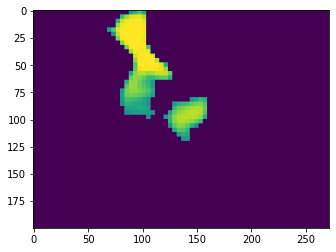

Index in original  tensor(16, device='cuda:0')


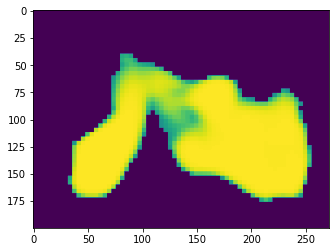

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


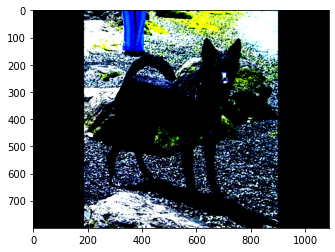

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


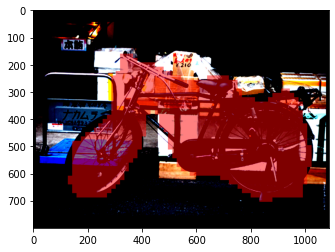

ins_pred:  torch.Size([2, 3872, 200, 272])
cate_pred:  torch.Size([2, 3872, 3])
Index in original  tensor(21, device='cuda:0')


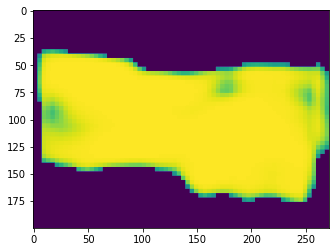

Index in original  tensor(13, device='cuda:0')


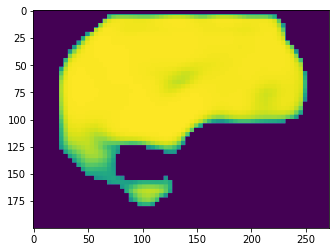

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


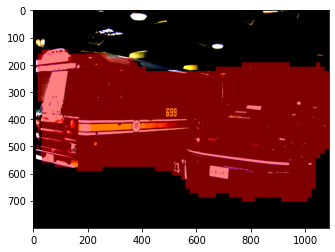

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


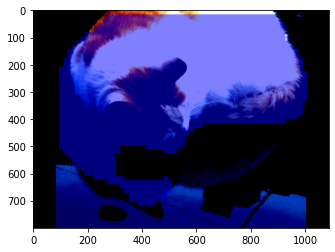

ins_pred:  torch.Size([2, 3872, 200, 272])
cate_pred:  torch.Size([2, 3872, 3])
Index in original  tensor(20, device='cuda:0')


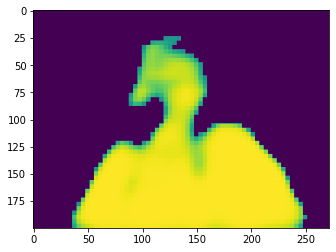

Index in original  tensor(22, device='cuda:0')


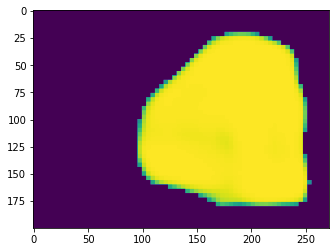

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


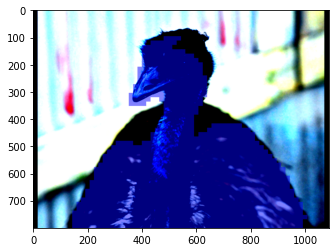

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


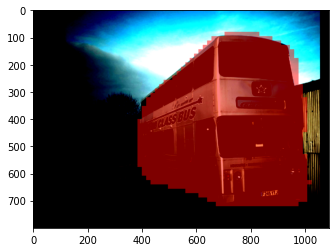

ins_pred:  torch.Size([2, 3872, 200, 272])
cate_pred:  torch.Size([2, 3872, 3])
Index in original  tensor(13, device='cuda:0')


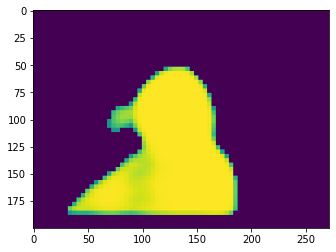

Index in original  tensor(12, device='cuda:0')


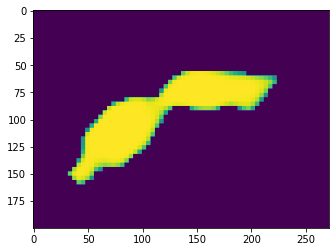

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


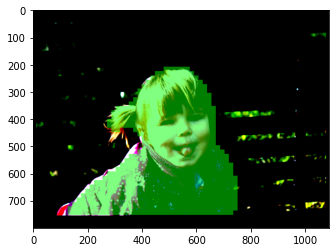

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


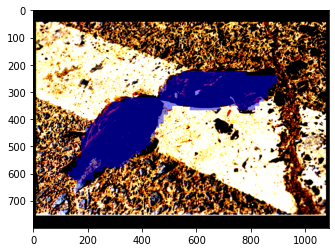

ins_pred:  torch.Size([2, 3872, 200, 272])
cate_pred:  torch.Size([2, 3872, 3])
Index in original  tensor(13, device='cuda:0')


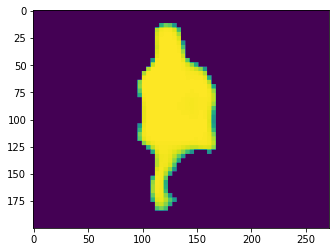

Index in original  tensor(9, device='cuda:0')


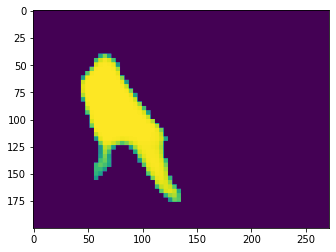

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


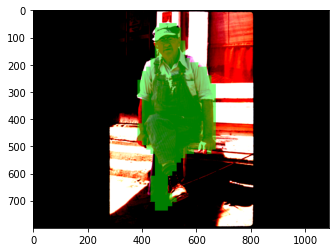

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


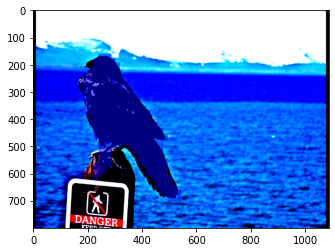

ins_pred:  torch.Size([2, 3872, 200, 272])
cate_pred:  torch.Size([2, 3872, 3])
Index in original  tensor(14, device='cuda:0')


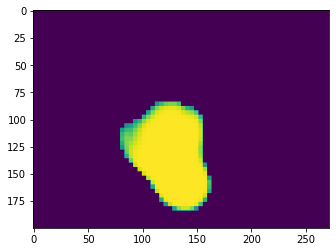

Index in original  tensor(11, device='cuda:0')


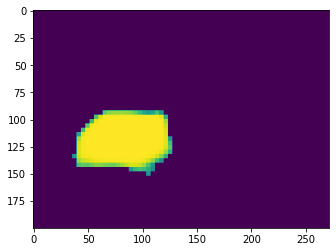

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


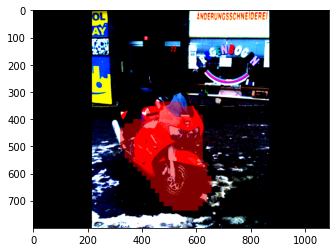

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


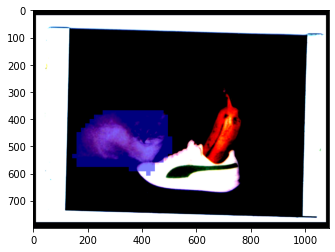

In [5]:
################ main infer.py ############################

from backbone import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy import ndimage
from dataset import *
from functools import partial
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import auc
#from solo_head import *

if __name__ == '__main__':
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  solo_head.eval()


  if resume == True:
    #checkpoint = torch.load(path+'/yolo_epoch'+str(epoch))
    checkpoint = torch.load(path)
    solo_head.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']

  
  with torch.no_grad():
      for iter, data in enumerate(test_loader, 0):
          img, label_list, mask_list, bbox_list = [data[i] for i in range(len(data))]
          img = img.to(device)
          backout = resnet50_fpn(img)
          fpn_feat_list = list(backout.values())
          for i in range(len(fpn_feat_list)):
              fpn_feat_list[i] = fpn_feat_list[i].to(device) 
          
          cate_pred_list, ins_pred_list = solo_head.forward(fpn_feat_list, eval=True)

          ins_gts_list, ins_ind_gts_list, cate_gts_list = solo_head.target(ins_pred_list,
                                                                            bbox_list,
                                                                            label_list,
                                                                            mask_list)

          NMS_sorted_scores_list, NMS_sorted_cate_label_list, NMS_sorted_ins_list = solo_head.PostProcess(ins_pred_list, cate_pred_list, (img.shape[2],img.shape[3]))
          solo_head.PlotInfer(NMS_sorted_scores_list, NMS_sorted_cate_label_list, NMS_sorted_ins_list, ["jet", "ocean", "Spectral"], img, iter)
          #solo_head.PlotGT(ins_gts_list,ins_ind_gts_list, cate_gts_list,["jet", "ocean", "Spectral"],img)
          
          if(iter==5):
            break



####CODE FOR mAP . RUN CELLS IN ORDER.





In [4]:
def solo_evaluation(NMS_sorted_scores_list, NMS_sorted_cate_label_list, NMS_sorted_ins_list, label_list, mask_list):
  match = {}
  scores = {}
  trues = {}

  match[1] = []
  match[2] = []
  match[3] = []

  scores[1] = []
  scores[2] = []
  scores[3] = []

  trues[1] = 0
  trues[2] = 0
  trues[3] = 0

  batch_size = len(mask_list)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  for i in range(batch_size):
    pred_scores = NMS_sorted_scores_list[i].to(device)
    pred_labels = NMS_sorted_cate_label_list[i].to(device)
    pred_masks = NMS_sorted_ins_list[i].to(device)

    gt_labels = label_list[i].to(device)
    gt_masks = mask_list[i][:,0,:,:].to(device)

    trues[1] += (gt_labels == 1).sum().item()
    trues[2] += (gt_labels == 2).sum().item()
    trues[3] += (gt_labels == 3).sum().item()

    if pred_scores.shape[0] == 0:
      for h in range(gt_labels.shape[0]):
        flag = gt_labels[h].int().item() 
        match[flag] += [0]
        scores[flag] += [0]
      continue

    # Reshape pred_masks and gt_masks to (num_masks, H*W)
    pred_masks = pred_masks.reshape(pred_masks.shape[0], pred_masks.shape[1]*pred_masks.shape[2])
    gt_masks = gt_masks.reshape(gt_masks.shape[0], gt_masks.shape[1]*gt_masks.shape[2])

    # Calculate IoU
    intersection = torch.matmul(pred_masks, gt_masks.T)
    
    pred_masks_area = pred_masks.sum(dim = 1).expand(intersection.shape[1],intersection.shape[0]).T
    gt_masks_area = gt_masks.sum(dim = 1).expand(intersection.shape[0],intersection.shape[1])
    
    union = pred_masks_area + gt_masks_area - intersection + 0.0
    #(i,j) represents IoU of pred_mask(i) with gt_mask(j) 
    IoU = intersection / union

    #(i,j) represents IoU.T of gt_mask(i) with pred_mask(j)
    IoU = IoU.T

    #For every ground truth mask find the corresponding predicted mask with maximum IoU
    match_pred_mask_IoU, match_pred_mask_idx    = torch.max(IoU,dim = 1)
    match_pred_mask_class                       = pred_labels[match_pred_mask_idx]
    match_pred_scores                           = pred_scores[match_pred_mask_idx]  
    
    IoU_thresh = 0.5
    for j in range(gt_labels.shape[0]):
      if match_pred_mask_IoU[j] > IoU_thresh and match_pred_mask_class[j] == gt_labels[j]:
        flag = gt_labels[j].int().item()
        match[flag] += [1]
        scores[flag] += [match_pred_scores[j].item()]
      else:
        flag = gt_labels[j].int().item()
        match[flag] += [0]
        scores[flag] += [match_pred_scores[j].item()]
        # scores[flag] += [0]

    non_match_flag = torch.ones(pred_labels.shape[0], dtype = torch.bool)
    non_match_flag[match_pred_mask_idx] = False
    
    if non_match_flag.sum() != 0:
      non_match_pred_mask_class = pred_labels[non_match_flag]
      non_match_pred_scores     = pred_scores[non_match_flag]

      for p in range(non_match_pred_mask_class.shape[0]):
        flag = non_match_pred_mask_class[p].int().item()
        match[flag] += [0]
        scores[flag] += [non_match_pred_scores[p].item()]
        # scores[flag] += [0]
    else:
      continue

  return match, scores, trues    

In [5]:
match_values = {}
score_values = {}
total_trues = {}

match_values[1] = []
match_values[2] = []
match_values[3] = []

score_values[1] = []
score_values[2] = []
score_values[3] = []

total_trues[1] = 0
total_trues[2] = 0
total_trues[3] = 0


AP_dict = {}
AP_dict[1] = []
AP_dict[2] = []
AP_dict[3] = []

# Test_loader has to be used
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
solo_head.eval()


for iter, data in enumerate(test_loader, 0):
  print(iter)
  '''
  img: (bz, 3, 800, 1088)
  label_list: list, len:bz, each (n_obj,)
  mask_list: list, len:bz, each (n_obj, 3, 800,1088)
  bbox_list: list, len:bz, each (n_obj, 4)
  '''
  img, label_list, mask_list, bbox_list = [data[i] for i in range(len(data))]
  img = img.to(device)

  with torch.no_grad():
    backout = resnet50_fpn(img)
  fpn_feat_list = list(backout.values())
            
  for i in range(len(fpn_feat_list)):
    fpn_feat_list[i] = fpn_feat_list[i].to(device) 
  
  cate_pred_list, ins_pred_list = solo_head.forward(fpn_feat_list, eval= True)

  '''
  # NMS_sorted_scores_list, list, len(bz), (keep_instance,)
  # NMS_sorted_cate_label_list, list, len(bz), (keep_instance,)
  # NMS_sorted_ins_list, list, len(bz), (keep_instance, ori_H, ori_W)
  '''
  NMS_sorted_scores_list, NMS_sorted_cate_label_list, NMS_sorted_ins_list = solo_head.PostProcess(ins_pred_list, cate_pred_list, (img.shape[2],img.shape[3]))
  print(NMS_sorted_scores_list)
  match, scores, trues = solo_evaluation(NMS_sorted_scores_list, NMS_sorted_cate_label_list, NMS_sorted_ins_list, label_list, mask_list)
  print('match: ', match)
  print('scores: ', scores )
  print('total_trues: ', trues)

  match_values[1] += match[1]
  match_values[2] += match[2]
  match_values[3] += match[3]

  score_values[1] += scores[1]
  score_values[2] += scores[2]
  score_values[3] += scores[3]

  total_trues[1] += trues[1]
  total_trues[2] += trues[2]
  total_trues[3] += trues[3]

  del match, scores, trues, NMS_sorted_scores_list, NMS_sorted_cate_label_list, NMS_sorted_ins_list, cate_pred_list, ins_pred_list, img, label_list, mask_list, bbox_list
  torch.cuda.empty_cache()




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0
ins_pred:  torch.Size([2, 3872, 200, 272])
cate_pred:  torch.Size([2, 3872, 3])
[tensor([], device='cuda:0', grad_fn=<IndexBackward>), tensor([0.3743], device='cuda:0', grad_fn=<IndexBackward>)]
match:  {1: [1], 2: [0], 3: []}
scores:  {1: [0.3742828071117401], 2: [0], 3: []}
total_trues:  {1: 1, 2: 1, 3: 0}
1
ins_pred:  torch.Size([2, 3872, 200, 272])
cate_pred:  torch.Size([2, 3872, 3])
[tensor([0.3721], device='cuda:0', grad_fn=<IndexBackward>), tensor([0.3512], device='cuda:0', grad_fn=<IndexBackward>)]
match:  {1: [0, 0], 2: [], 3: [1]}
scores:  {1: [0.37205958366394043, 0.3511861562728882], 2: [], 3: [0.3511861562728882]}
total_trues:  {1: 2, 2: 0, 3: 1}
2
ins_pred:  torch.Size([2, 3872, 200, 272])
cate_pred:  torch.Size([2, 3872, 3])
[tensor([0.3668], device='cuda:0', grad_fn=<IndexBackward>), tensor([0.3780], device='cuda:0', grad_fn=<IndexBackward>)]
match:  {1: [1], 2: [], 3: [1]}
scores:  {1: [0.37801939249038696], 2: [], 3: [0.3667519688606262]}
total_trues:  {1: 1, 2: 0,

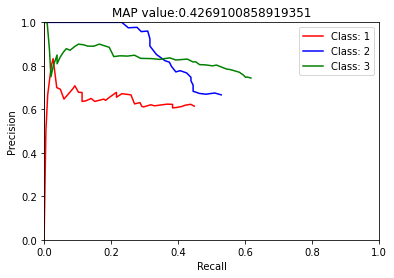

In [7]:
from sklearn.metrics import auc
area = 0
for j in range(1,4):
  if len(match_values[j]) > 0:
    # maximum_score = score_values[j].max()
    maximum_score = max(score_values[j])
    ln= np.linspace(0,maximum_score,num=100)
    precision_mat= np.zeros(101)
    recall_mat= np.zeros(101)
    for i ,th in enumerate(ln):
      # th = 0.2
      # match_values[j]         = [ 1   0  1   0  0 0 0 0  1  1  1  1]
      # score_values[j]         = [.5  .5 .3  .9  0 0 0 0 .1 .2 .8 .3]
      # score_values[j] > th    = [ T   T  T   T  F F F F  F  F  T  T]
      # matches                 = [ 1   0  1   0                 1  1]
      # total_positive should be 6
      # TP should be 4
      matches = np.array(match_values[j])[score_values[j] > th]
      TP = matches.sum()
      total_positive = matches.shape[0]
      # total_positive = sum(match_values[j])
      
      precision = 1
      if total_positive > 0:
        precision = TP/total_positive
      recall =1
      if total_trues[j] > 0:
        recall = TP/total_trues[j]
      precision_mat[i] = precision
      recall_mat[i] = recall
    precision_mat[100] = 1
    recall_mat[100] = 0
    plt.figure(0)
    plt.ylim([0,1])
    plt.xlim([0,1])
    
    if j == 1:
      plt.plot(recall_mat,precision_mat, 'r-', label = ("Class: " + str(1) ))
    if j == 2:
      plt.plot(recall_mat,precision_mat, 'b-', label = ("Class: " + str(2) ))
    if j == 3:
      plt.plot(recall_mat,precision_mat, 'g-', label = ("Class: " + str(3) ))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    #plt.title("Class: "+ str(j))
    #plt.savefig("Class: " + str(j) + " curve")
    sorted_ind=np.argsort(recall_mat)
    sorted_recall=recall_mat[sorted_ind]
    sorted_precision=precision_mat[sorted_ind]
    
    area += auc(sorted_recall,sorted_precision)

MAP = area/3
plt.title('MAP value:' + str(MAP))
plt.savefig("7.7 curve.png")